# Time series forcasting with tensorflow + milestone project 3
This isnt financial advice

Lets write some tensorflow code to predict the price of bitcoin

# Factors affecting time series prediction problems
1. How well we understand the factors that contributes to it.
2. How much data is available
3. How much similar the future is to past
4. wether the forcast can affect the thing we are trying to forcast

In [1]:
## Get the data
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-12-02 21:41:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.002s  

2022-12-02 21:41:42 (70.9 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



We are going to use the historic data of bitcoin to try and predict the price of bitcoin in future

## Importing time series data

In [2]:
# Import using pandas
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have
len(df)

2787

We have collected the historical price of bitcoin for the last 8 years but the are only 2787 samples but a neural network model like milions of sample

**Note** The **Sesonality** of a time series dataset is reffered as the number of samples per year So for our Bitcoin data it has a sesonality of 365 as we collect one sample per day

In [5]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


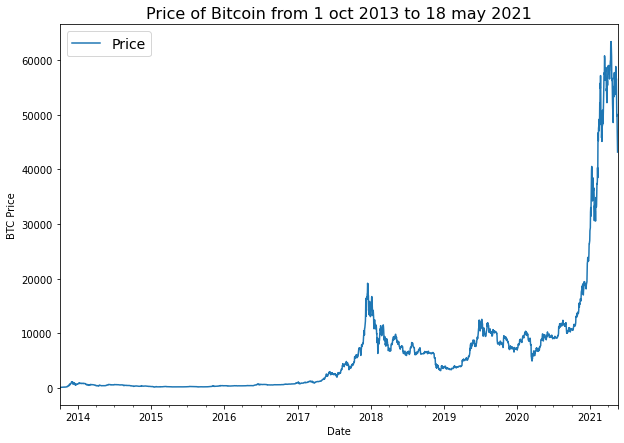

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021",fontsize=16)
plt.legend(fontsize=14);

In [7]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv","r") as f:
  csv_reader = csv.reader(f,delimiter=",")
  next(csv_reader) # Skips frist line (This gets rid of the columns title)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],"%Y-%m-%d")) # Gets the date as dates not strings
    btc_price.append(float(line[2])) # get the closing price as float
# view the first 10 of each 
timesteps[:10],btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

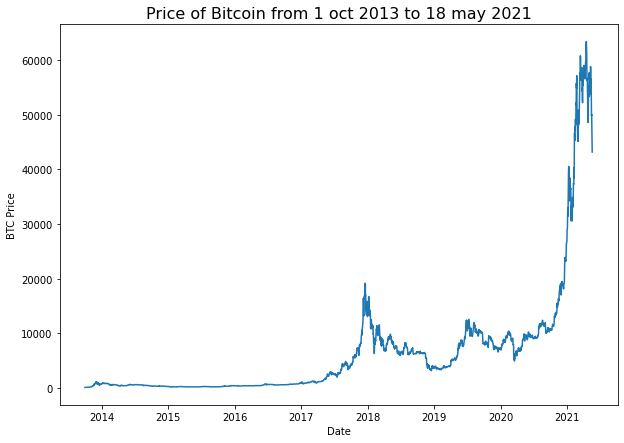

In [8]:
# Plot from csv
plt.figure(figsize=(10,7))
plt.plot(timesteps,btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021",fontsize=16)
plt.xlabel("Date")

## Format Data part 1 : Create training and test sets 

### The wrong way

In [9]:
# Get bitcoin data array 
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10],prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Wrong way to make train test sets fpr time series

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(timesteps,
                                                 prices,
                                                 test_size=0.2,
                                                 random_state=42)

x_train.shape,x_test.shape,y_train.shape,y_train.shape

((2229,), (558,), (2229,), (2229,))

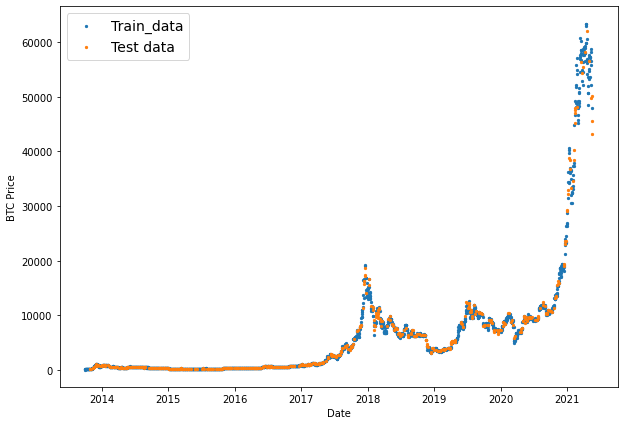

In [11]:
# Lets plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(x_train,y_train,s=5,label="Train_data")
plt.scatter(x_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Notice the mixed dots 😆 Thats why its wrong  

##  Create the train and test sets the right way 

### Time series split

In [12]:
split_size = int(0.8*len(prices))
# Create train data splits
x_train,y_train = timesteps[:split_size],prices[:split_size]
# Create test data splits (everything beyond the split size )
x_test,y_test = timesteps[split_size:],prices[split_size:]
len(x_train),len(y_train),len(x_train),len(y_train)

(2229, 2229, 2229, 2229)

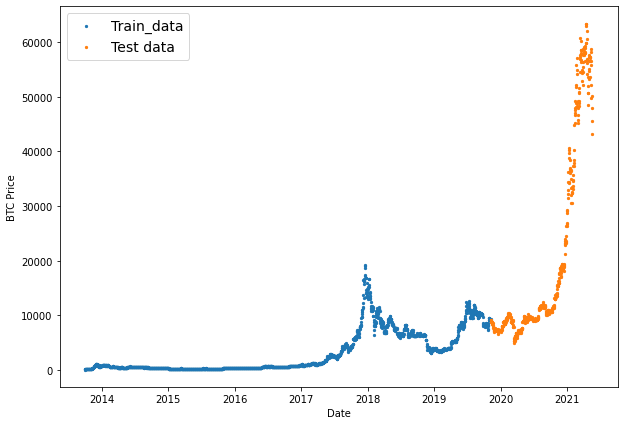

In [13]:
# Lets plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(x_train,y_train,s=5,label="Train_data")
plt.scatter(x_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Now thats the right thing

## Create a ploting fuction

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

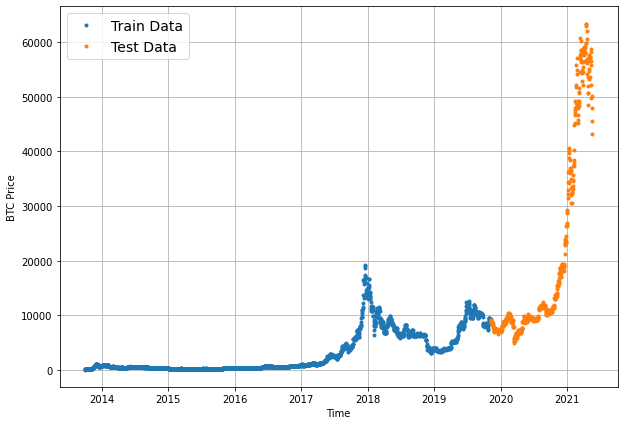

In [15]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_train,values=y_train,label="Train Data")
plot_time_series(timesteps=x_test,values=y_test,label="Test Data")

## Modeling experiments
lets run a series of modelling experiments

# Lets build a naive model (model 0)
The formula is $$\hat{y}_{t} = y_{t-1}$$

The prediction at timestemp t is the same as previous

In [16]:
# Create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10] ,naive_forecast[-10:]


(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [17]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

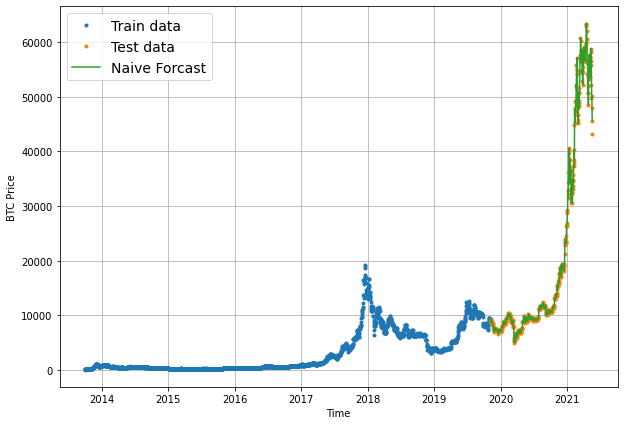

In [18]:
# Plot naive forcast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_train,values=y_train,label="Train data")
plot_time_series(timesteps=x_test,values=y_test,label="Test data")
plot_time_series(timesteps=x_test[1:],values=naive_forecast,format="-",label="Naive Forcast")

from numpy import number
## Evaluating a time series model

lets look at some evaluation metrics for time series forecasting

we are working on a regression model like thing we are predicting a number

so a few comman regression metrics are

* MAE
* MSE
* RMSE
* MASE
*sMASE

In [19]:
import tensorflow as tf

In [20]:
# Mase implementation
def mean_absolute_scaled_error(y_true,y_pred):
  """
  Implement MASE
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return (mae/mae_naive_no_season)

In [21]:
mean_absolute_scaled_error(y_test[1:],naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [22]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [24]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [25]:
tf.reduce_min(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>

In [26]:
tf.reduce_max(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>

## Format Data part 2 : Windowing our data set 

why do we window ?

we window our time series dataset to turn our data into a supervised 
learning problem.


In [27]:
len(y_train)

2229

In [28]:
btc_price[:7] ,btc_price[7]

([123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795],
 123.033)

In [29]:
# lets setup global variables for window and horizon size 
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [30]:
# Create function to label windowed data
def get_labelled_window(x,horizon=HORIZON):
  '''
  Create labels for windowed dataset
  
  E.g if horizon =1
  Input: [0,1,2,3,4,5,6,7] ------> Output: ([0,1,2,3,4,5,6] , [7])
  
  '''
  return (x[:,:-horizon],x[:,-horizon:])

In [31]:
# Test out the window labelling function
test_window, test_label = get_labelled_window (tf.expand_dims(tf.range(8)+1,axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

we need to do the above preprocessing on the complete time series

We can use numpy array indexing instead of for loops to speed things up

Let's write a function which:

* 1. Creates a window step of specific window size, for example: [[0, 1, 2, 3, 4, 5, 6, 7]]


* 2. Uses NumPy indexing to create a 2D of multiple window steps, for example:

        [[0, 1, 2, 3, 4, 5, 6, 7],
        
        [1, 2, 3, 4, 5, 6, 7, 8],
         [2, 3, 4, 5, 6, 7, 8, 9]]

* 3.Uses the 2D array of multuple window steps to index on a target series

* 4.Uses the get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon

In [32]:
import numpy as np
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)

  return windows, labels

In [33]:
full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [34]:
# View the first 3
for i in range (3):
  print(f"Windsows:{full_windows[i]}--> Label {full_labels[i]}")

Windsows:[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]--> Label [123.033]
Windsows:[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]--> Label [124.049]
Windsows:[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]--> Label [125.96116]


In [35]:
np.expand_dims(np.arange(len(prices)-(7+1-1)),axis=0).T

array([[   0],
       [   1],
       [   2],
       ...,
       [2777],
       [2778],
       [2779]])

In [36]:
np.expand_dims(np.arange(7+1),axis=0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [37]:
len(prices)

2787

In [38]:
f=tf.keras.preprocessing.timeseries_dataset_from_array(prices,sequence_length=7,targets=None ,batch_size=1)

In [39]:
for i in f:
  a=tf.squeeze(i)
  print(tf.squeeze(i))
  break

tf.Tensor([123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], shape=(7,), dtype=float64)


In [40]:
get_labelled_window(np.expand_dims(a,axis=0))

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533]]),
 array([[121.795]]))

## Turning windows into training and test sets


In [41]:
# Make the train test splits
def make_train_test_split(windows,labels,test_split=0.2):
  """
  Split matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # This will default to 80% train and 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return(train_windows,test_windows,train_labels,test_labels)

In [42]:
# Create train and test windows
train_windows,test_windows,train_labels,test_labels = make_train_test_split(full_windows,full_labels)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(2224, 556, 2224, 556)

In [43]:
train_windows[:5],train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

## Make a Modeling check point

Because our model's performance will fluctuate from experiment to experiment we are going to write a model checkpoint so we can compare appels to appels.

More specifically we want to compare each of our models best performance against the other models best performance.

for example if our model performs the best on epoch 55 (but we are training for 100 epochs), we want to load and evaluate the model saved on epoch 55

We can create a modelling checkpoint callbacks by using tf keras callback model checkpoints

In [44]:
import os
# Create a function to implement the model callback checkpoint with a specific filename
def create_model_checkpoint(model_name,save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                            verbos=0,
                                            save_best_only=True)



## Model 1: Dense model (window=7 horizon=1)

our first deep model is going to be simple dense model
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear or no activation
* Adam optimizer and MAE loss fuction
* Batch size of 128
* 100 epochs

Why these values ?

These were picked out through experimentations

**Hyperparameters** = values a machine learning practitioner can adjust themselves

**Parameters** = values a model learns on its own

In [45]:
import tensorflow as tf 
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
# 1. Construct Model
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is just like having no activation at all
],name="model_1_dense")# name our model so we can save it
# 2. Compile
model_1.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])
# 3. Fit the model
model_1.fit(x = train_windows,
            y = train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 49ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9993 - val_mae: 1005.9993 - val_mse: 3441833.2500
Epoch 3/100
18/18 [==============================] - 1s 29ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2862 - val_mae: 923.2861 - val_mse: 2868220.7500
Epoch 4/100
18/18 [==============================] - 1s 31ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5781 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.5000
Epoch 5/100
18/18 [==============================] - 0s 27ms/step - loss: 165.0894 - mae: 165.0894 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 0s 26ms/step - loss: 158.5

In [46]:
# Evaluate model on test data
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [47]:
# Load in the best performing model
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

## Making forcast with a model (on the test set)

It takes in a model  and does the following 
1. Takes some input data
2. Passes the data to the models predict method
3. Returns the predicted output

In [48]:
def make_preds(model,input_data):
  """
  Uses model to make predictions on input data
  """
  forcast = model.predict(input_data)
  return(tf.squeeze(forcast))

In [49]:
model_1_preds=make_preds(model_1,test_windows)
len(model_1_preds),model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [50]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [51]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

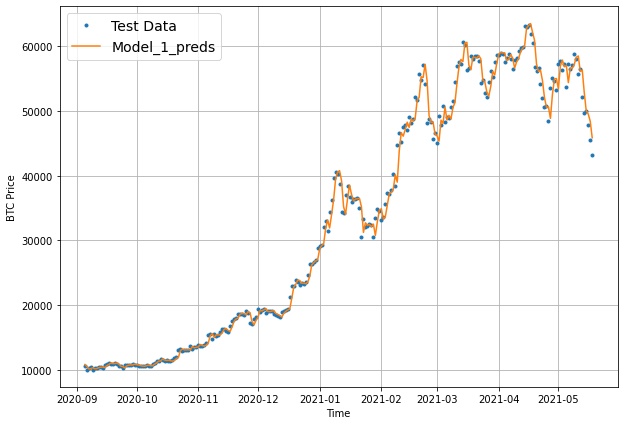

In [52]:
# Lets Plot our model 1 predictions
offset = 300

plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting 
plot_time_series(timesteps = x_test[-len(test_windows):],values = test_labels[:,0],start=offset , label="Test Data")

plot_time_series(timesteps = x_test[-len(test_windows):],values =model_1_preds,start=offset,format = "-",label = "Model_1_preds")

In [53]:
input_data = prices[:-30]
targets = prices[30:]
Windows=tf.keras.preprocessing.timeseries_dataset_from_array(data=input_data,targets=targets,sequence_length=30,batch_size=None)

In [54]:
prices[:32]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
       126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
       152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
       180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ,
       196.02499, 198.04883])

In [55]:
windows = []
labels = []
for i,x in Windows:
    windows.append(i)
    labels.append(x)

In [56]:
windows[:10],labels[:10],len(windows),len(labels)

([<tf.Tensor: shape=(30,), dtype=float64, numpy=
  array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ])>,
  <tf.Tensor: shape=(30,), dtype=float64, numpy=
  array([125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499])>,
  <tf.Tensor: shape=(30,), dtype=float64, numpy=
  array([108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 12

In [57]:
len(windows),len(labels)

(2728, 2728)

In [58]:
2728*0.8

2182.4

In [59]:
train_windows = np.array(windows[:2183])
train_labels = np.array(labels[:2183])
test_windows = np.array(windows[2183:])
test_labels = np.array(labels[2183:])

In [60]:
train_windows[:3],test_windows[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [61]:
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2183, 2183, 545, 545)

## Creating Dense Model_2

In [62]:
import tensorflow as tf 
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
# 1. Construct Model
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is just like having no activation at all
],name="model_2_dense")# name our model so we can save it
# 2. Compile
model_2.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])
# 3. Fit the model
model_2.fit(x = train_windows,
            y = train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 1045.5662 - mae: 1045.5662 - mse: 4253932.5000 - val_loss: 3442.8511 - val_mae: 3442.8511 - val_mse: 27193866.0000
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 425.5170 - mae: 425.5170 - mse: 786516.3750 - val_loss: 1321.6090 - val_mae: 1321.6090 - val_mse: 4168320.2500
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 269.2410 - mae: 269.2410 - mse: 347976.1875 - val_loss: 1359.9800 - val_mae: 1359.9800 - val_mse: 5218970.0000
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 216.6969 - mae: 216.6969 - mse: 216993.7500 - val_loss: 947.8182 - val_mae: 947.8182 - val_mse: 2766874.0000
Epoch 5/100
18/18 [==============================] - 0s 28ms/step - loss: 193.8449 - mae: 193.8449 - mse: 185441.9688 - val_loss: 883.8165 - val_mae: 883.8165 - val_mse: 2574323.7500
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 178

In [63]:
# Evaluate model_2 on test data
smodel_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 529.1037 - mae: 529.1037 - mse: 1027048.0625


[529.1036987304688, 529.1036987304688, 1027048.0625]

In [64]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 529.1037 - mae: 529.1037 - mse: 1027048.0625


[529.1036987304688, 529.1036987304688, 1027048.0625]

In [65]:
# Get the forcast predictions
model_2_preds = make_preds(model_2,input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [66]:
test_labels.shape

(545,)

In [67]:
model_2_results = evaluate_preds(y_true = tf.squeeze(test_labels),y_pred = model_2_preds)
model_2_results

{'mae': 529.1037,
 'mse': 1027047.94,
 'rmse': 1013.4337,
 'mape': 2.7406445,
 'mase': 1.0736358}

In [68]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

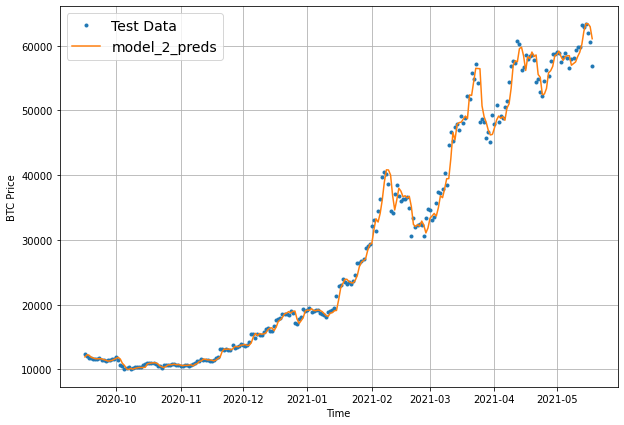

In [76]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset while ploting
plot_time_series(timesteps = x_test[-len(test_windows):], values = test_labels[:],start = offset, label ="Test Data")
plot_time_series(timesteps = x_test[-len(test_windows):], values=model_2_preds, start=offset, format="-",label="model_2_preds")

## Creating model 3

In [77]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE,horizon = HORIZON)
len(full_windows),len(full_labels)

(2751, 2751)

In [78]:
train_windows , test_windows , train_labels , test_labels = make_train_test_split(windows = full_windows, labels=full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2200, 2200, 551, 551)

In [79]:
# This model contains window size of 30 and horizon of 7
import tensorflow as tf 
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
# 1. Construct Model
model_3 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is just like having no activation at all
],name="model_3_dense")# name our model so we can save it
# 2. Compile
model_3.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])
# 3. Fit the model
model_3.fit(x = train_windows,
            y = train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 2s 72ms/step - loss: 1476.6752 - mae: 1476.6752 - mse: 10390733.0000 - val_loss: 3088.5613 - val_mae: 3088.5613 - val_mse: 24386346.0000
Epoch 2/100
18/18 [==============================] - 0s 27ms/step - loss: 552.8943 - mae: 552.8943 - mse: 1336176.8750 - val_loss: 2462.4548 - val_mae: 2462.4548 - val_mse: 17112268.0000
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 435.1978 - mae: 435.1978 - mse: 893449.0000 - val_loss: 2283.1484 - val_mae: 2283.1484 - val_mse: 14950889.0000
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 391.9787 - mae: 391.9787 - mse: 745983.8125 - val_loss: 1975.1218 - val_mae: 1975.1218 - val_mse: 11680637.0000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 357.9485 - mae: 357.9485 - mse: 627137.9375 - val_loss: 2000.1556 - val_mae: 2000.1556 - val_mse: 11665231.0000
Epoch 6/100
18/18 [==============================] - 1s 39ms/step 